<center>
    <h1>MODEL TRAINING:</h1>
</center>

<center>
    <h4>
    The dataset used here is <b><span style="color:blue"><a href="Step2-DataCleaning/step2/step2-Completed.csv">"Scripts/Step2-DataCleaning/step2/step2-Completed.csv"</a>.</span></b><br>
This dataset was created as a part of step 2 of data preprocessing.</span></b>
<br><br>
For the web scrapping python script click below:<br>
<span style="color:blue"><a href="Step1-WebScrapper/scrapper.py">Scrapper.py</a></span>
<br><br>
For step 1 notebook of data preprocessing click below:<br>
<span style="color:blue"><a href="Step2-DataCleaning/Step1/Step1-FixingStructuralErrors.ipynb">Step1-FixingStructuralErrors.ipynb</a></span>
<br><br>For step 2 notebook of Exploratory Data Analysis click below:<br>
<span style="color:blue"><a href="Step2-DataCleaning/Step2/Step2-EDA.ipynb">Step2-EDA.ipynb</a></span>
    </h4>
</center>

In [10]:
from scipy import stats

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


from pickle import dump

from sklearn.preprocessing import QuantileTransformer

from sklearn.model_selection import train_test_split

In [11]:
#pd.set_option('display.max_rows', 300)
pd.set_option('display.max_columns', None)
df = pd.read_csv("Step2-DataCleaning/step2/step2-Completed.csv")

orignal_df_cols_name = list(df.columns)

In [12]:
#### SAVING A TEXT FILE WHICH WILL INCLUDE ALL NUMERIC FEATURE NAME AND CATEGORIC FEATURE NAME WITH ITS UNIQUE VALUES ###
numerical_cols = list(df._get_numeric_data().columns)
categoric_cols = list(df.select_dtypes(exclude=np.number).columns)

with open("Models/Feature-Options/options.txt", 'w') as f:
    for i in df.columns:
        if i in numerical_cols:
            if i == "year":
                option = df[i].unique()
                option_str = f"{i}:"
                for x in option:
                    if x != option[-1]:
                        option_str += f"{str(x)},"
                    else:
                        option_str += f"{str(x)}"
                f.write(f"{option_str}\n")
            else:
                f.write(f"{i}\n")
        else:
            option = df[i].unique()
            option_str = f"{i}:"
            for x in option:
                if x != option[-1]:
                    option_str += f"'{str(x)}',"
                else:
                    option_str += f"'{str(x)}'"
            f.write(f"{option_str}\n")

In [13]:
def train_df_quantile_transform_and_OneHotEncoding(x_df, y_df):
    '''
    returns transformed(QuantileTransformer) & One Hot Encoded x_train, y_train
    '''
    inner_df = pd.concat([y_df, x_df], axis = 1)
    numeric_df = inner_df._get_numeric_data()
    categoric_df = inner_df.select_dtypes(exclude=np.number)

    transformer = QuantileTransformer(output_distribution="normal")
    transformer.fit(numeric_df)
    new_df = transformer.transform(numeric_df)
    new_df = pd.DataFrame(new_df)
    new_df.columns = numerical_cols

    new_df = new_df.reset_index(drop=True)
    categoric_df = categoric_df.reset_index(drop=True)
    final_df = pd.concat([new_df, categoric_df], axis = 1)
    final_df = pd.get_dummies(data=final_df, columns=categoric_cols)
    
    return final_df.loc[:, 'year':], final_df["price_in_aud"]

In [14]:
def test_df_quantile_transform_and_OneHotEncoding(x_df, y_df):
    '''
    returns transformed(QuantileTransformer) & One Hot Encoded x_test, y_test
    '''
    
    ## FOR INDEPENDENT FEATURES 'x_df'
    x_df_numeric = x_df._get_numeric_data()
    x_df_categoric = x_df.select_dtypes(exclude=np.number)

    transformer = QuantileTransformer(n_quantiles=440, output_distribution="normal")
    transformer.fit(x_df_numeric)
    x_df_numeric = transformer.transform(x_df_numeric)
    x_df_numeric = pd.DataFrame(x_df_numeric)
    x_df_numeric.columns = numerical_cols[1:]
    
    x_df_numeric = x_df_numeric.reset_index(drop=True)
    x_df_categoric = x_df_categoric.reset_index(drop=True)
    
    x_df_ = pd.concat([x_df_numeric, x_df_categoric], axis = 1)
    x_df_ = pd.get_dummies(data=x_df_, columns=categoric_cols)
    
    dump(transformer, open('Models/Independent_Features_QuantileTransformer.pkl', 'wb')) #saving the independent features transformer object for transforming values later on while making predictions
    
    
    ## FOR TARGET FEATURE 'y_df'
    trg = QuantileTransformer(n_quantiles=440, output_distribution="normal")
    trg.fit(y_df.to_numpy().reshape(-1,1))
    y_df_ = trg.transform(y_df.to_numpy().reshape(-1,1))
    y_df_ = y_df_.flatten()
    y_df_ = pd.Series(y_df_)
    
    dump(trg, open('Models/Target_Feature_QuantileTransformer.pkl', 'wb')) #saving the Target feature transformer object for transforming values later on while making predictions

    return x_df_, y_df_

In [123]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import BayesianRidge, LinearRegression, Ridge, Lasso
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor

X_train, X_test, y_train, y_test = train_test_split(df.loc[:, 'year':], df["price_in_aud"], random_state=80, test_size=0.2, shuffle=True)

X_train_, y_train_ = train_df_quantile_transform_and_OneHotEncoding(X_train, y_train)
X_test_, y_test_ = test_df_quantile_transform_and_OneHotEncoding(X_test, y_test)

models = [
    DecisionTreeRegressor(),
    MLPRegressor(),
    RandomForestRegressor(),
    GradientBoostingRegressor(),
    SVR(),
    BayesianRidge(),
    LinearRegression(),
    Ridge(),
    Lasso(),
    KernelRidge(),
    KNeighborsRegressor(),
    GaussianProcessRegressor()
]

for model in models:
    model.fit(X_train_, y_train_)

model_names = [
    "    DecisionTreeRegressor",
    "             MLPRegressor",
    "    RandomForestRegressor",
    "GradientBoostingRegressor",
    "Support Vector Regression",
    "            BayesianRidge",
    "         LinearRegression",
    "                    Ridge",
    "                    Lasso",
    "              KernelRidge",
    "      KNeighborsRegressor",
    " GaussianProcessRegressor"
]

for model, name in zip(models, model_names):
    print(name + ": {:.4f}%".format(model.score(X_test_, y_test_) * 100))

    DecisionTreeRegressor: 86.5459%
             MLPRegressor: 92.5048%
    RandomForestRegressor: 91.7414%
GradientBoostingRegressor: 90.3272%
Support Vector Regression: 88.5863%
            BayesianRidge: 87.1743%
         LinearRegression: 87.2639%
                    Ridge: 87.2051%
                    Lasso: -0.0001%
              KernelRidge: 87.2050%
      KNeighborsRegressor: 88.8646%
 GaussianProcessRegressor: -1071.6244%


<span style="color:red"><b>
    From the above models we'll use "MLPRegressor; Neural Network" and perform hyperparameter Tuning for better accuracy.
</span></b>

<center>
    <h1>
        <span style="color:red"><b>Hyperparameters tuning</b></span>
    </h1>
</center>

In [164]:
from sklearn.neural_network import MLPRegressor

X_train, X_test, y_train, y_test = train_test_split(df.loc[:, 'year':], df["price_in_aud"], random_state=80, test_size=0.2, shuffle=True)

X_train_, y_train_ = train_df_quantile_transform_and_OneHotEncoding(X_train, y_train) # Quantile transforming + One hot encoding train dataset
X_test_, y_test_ = test_df_quantile_transform_and_OneHotEncoding(X_test, y_test) # Quantile transforming + One hot encoding test dataset


model = MLPRegressor(learning_rate_init=0.001019, hidden_layer_sizes=(1650,200), batch_size=60) #160
model.fit(X_train_, y_train_)
print("Model accuracy : {:.4f}%".format(model.score(X_test_, y_test_) * 100))

Model accuracy : 93.8565%


In [165]:
# saving the model
dump(model, open('Models/Model.pkl', 'wb'))

<center>
    <h1>
        <span style="color:red"><b>Plotting actual vs predictions</b></span>
    </h1>
</center>

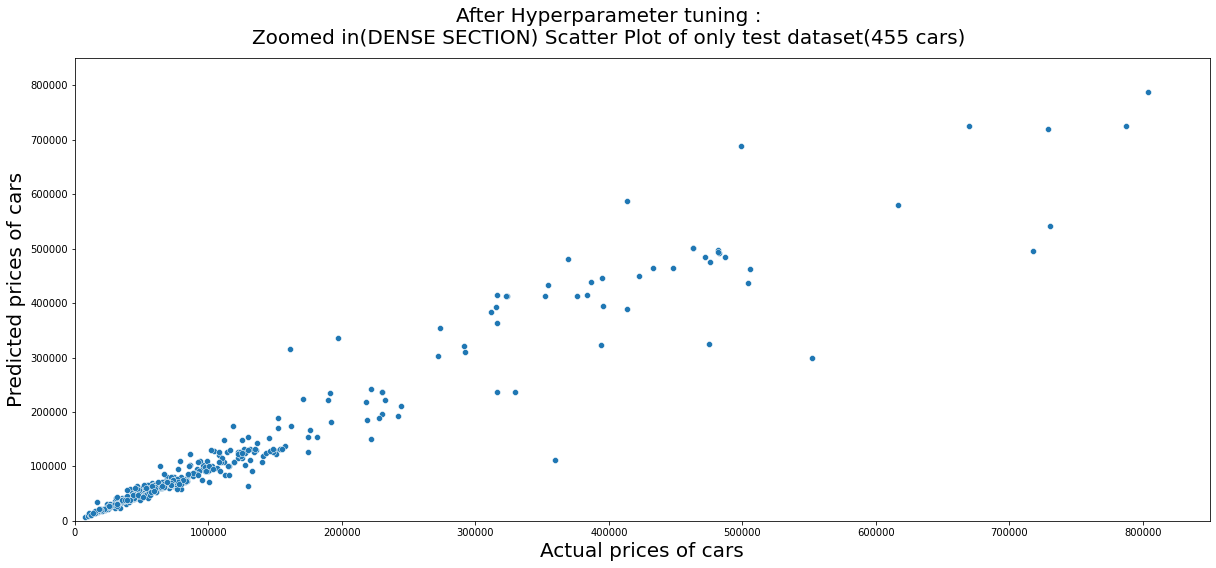

In [169]:
from pickle import load

# loading the model
model = load(open('Models/Model.pkl', 'rb'))

# loading the independent features transformer
transformer_independent = load(open('Models/Independent_Features_QuantileTransformer.pkl', 'rb'))

# loading the target feature transformer
transformer_target = load(open('Models/Target_Feature_QuantileTransformer.pkl', 'rb'))


y_predict = best_random.predict(X_test_) #X_test_ is already transformed before
y_predict_inverse_transformed = transformer_target.inverse_transform(y_predict.reshape(-1,1))

y_test_flattened = y_test.to_numpy().flatten()
y_predict_inverse_transformed = y_predict_inverse_transformed.flatten()


fig, ax = plt.subplots(1,1, figsize=(17,8))
fig.suptitle(f'After Hyperparameter tuning :\nZoomed in(DENSE SECTION) Scatter Plot of only test dataset({len(y_test)} cars)', fontsize=20)
p = sns.scatterplot(x=y_test_flattened, y=y_predict_inverse_transformed)

p.set_xlabel("Actual prices of cars", fontsize = 20)
p.set_ylabel("Predicted prices of cars", fontsize = 20)

plt.xlim(0,0.85e6)
plt.ylim(0,0.85e6)

plt.tight_layout()
plt.show()

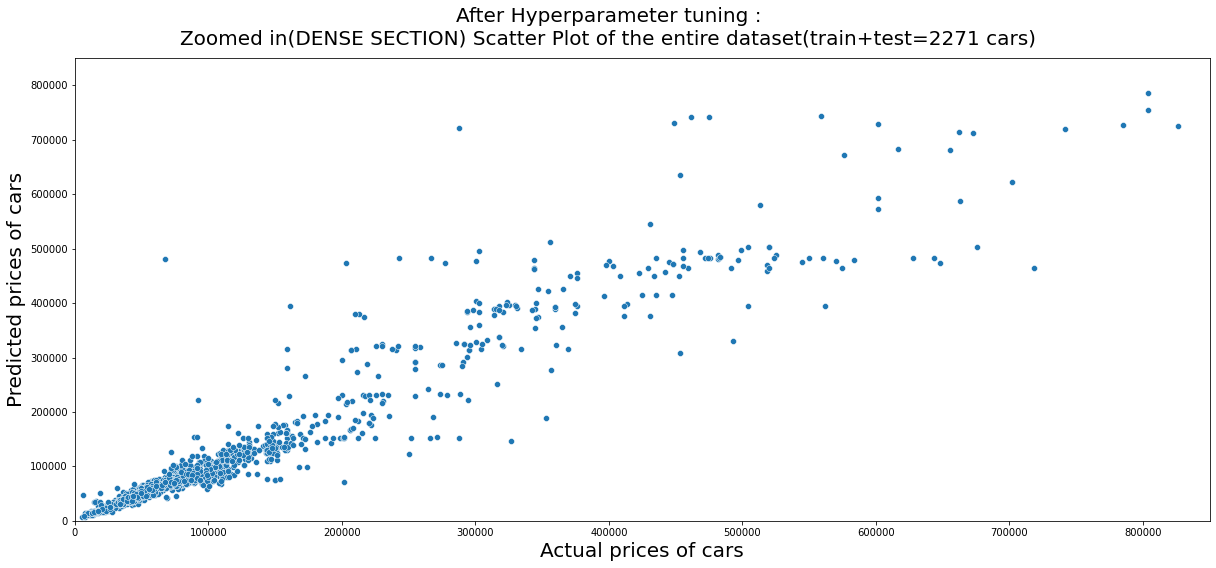

In [171]:
from pickle import load

# loading the model
model = load(open('Models/Model.pkl', 'rb'))

# loading the independent features transformer
transformer_independent = load(open('Models/Independent_Features_QuantileTransformer.pkl', 'rb'))

# loading the target feature transformer
transformer_target = load(open('Models/Target_Feature_QuantileTransformer.pkl', 'rb'))


y_predict = best_random.predict(X_train_) #X_test_ is already transformed before
y_predict_inverse_transformed = transformer_target.inverse_transform(y_predict.reshape(-1,1))

y_test_flattened = y_train.to_numpy().flatten()
y_predict_inverse_transformed = y_predict_inverse_transformed.flatten()


fig, ax = plt.subplots(1,1, figsize=(17,8))
fig.suptitle(f'After Hyperparameter tuning :\nZoomed in(DENSE SECTION) Scatter Plot of the entire dataset(train+test={df.shape[0]} cars)', fontsize=20)
p = sns.scatterplot(x=y_test_flattened, y=y_predict_inverse_transformed)

p.set_xlabel("Actual prices of cars", fontsize = 20)
p.set_ylabel("Predicted prices of cars", fontsize = 20)

plt.xlim(0,0.85e6)
plt.ylim(0,0.85e6)

plt.tight_layout()
plt.show()